In [1]:
from google.colab import drive
drive.mount('/mnt/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /mnt/drive



## Steps

1. Network (test DB), perf > 85%
2. Test on image 48x48
3. Production script (load model, load image, estimate)
4. Adversarial image using gradient
5. Test modified image
6. L2 constraint

In [2]:
!pip install tensorview

     |████████████████████████████████| 71kB 4.2MB/s 
     |████████████████████████████████| 174kB 12.7MB/s 
     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 92kB 8.5MB/s 
     |████████████████████████████████| 1.2MB 58.9MB/s 
     |████████████████████████████████| 450kB 54.5MB/s 
     |████████████████████████████████| 3.8MB 60.1MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
     |████████████████████████████████| 81kB 14.6MB/s 
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114210 sha256=a8fc0f8eabe57fa16930fcdf8e724ab9f9bafeb2fad980de19eed3e4a048beb3
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
  Created wheel for pyppeteer: filename=pyppeteer-0.0.25-cp36-none-any.whl size=78360 sha256=ec3439e57afb64c89783232222f4a8570e0059a2bcc95529d9dbb4da44036548
  Stored in directory: /root/.cache/pip/wheels/34/e0/5d/070e22ecee

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, optimizers, regularizers, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D
import seaborn as sns
import pandas as pd
import tensorview as tv
import sklearn.metrics as skMetrics
from skimage import io, transform
from pathlib import Path
import tensorflow as tf

## Helpers

In [0]:
class DataSet(object):
    def __init__(self, path, filename_data, filename_gender, nbdata, batch_size=128):
        self.path = path
        self.filename_data = filename_data
        self.filename_gender = filename_gender
        self.nbdata = nbdata
        self.name = filename_data
        # taille des images 48*48 pixels en niveau de gris
        self.width = self.height = 48
        self.channels = 1
        self.dim = self.width * self.height * self.channels
        self.data = None
        self.label = None
        self.batch_size = batch_size

    def load(self):
        f = open(self.path.joinpath(self.filename_data), 'rb')
        self.data = np.empty(self.shape(True), dtype=np.float32)
        for i in range(self.nbdata):
            self.data[i, :] = np.fromfile(f, dtype=np.uint8, count=self.dim) \
                .reshape(self.shape())
        f.close()

        f = open(self.path.joinpath(self.filename_gender), 'rb')
        self.label = np.empty([self.nbdata, 2], dtype=np.float32)
        for i in range(self.nbdata):
            self.label[i, :] = np.fromfile(f, dtype=np.float32, count=2)
        f.close()

        self.data = (self.data - 128.0) / 256.0

        tmpdata = np.empty([1, self.dim], dtype=np.float32)
        tmplabel = np.empty([1, 2], dtype=np.float32)
        arr = np.arange(self.nbdata)
        np.random.shuffle(arr)
        tmpdata = self.data[arr[0], :]
        tmplabel = self.label[arr[0], :]
        for i in range(self.nbdata - 1):
            self.data[arr[i], :] = self.data[arr[i + 1], :]
            self.label[arr[i], :] = self.label[arr[i + 1], :]
        self.data[arr[self.nbdata - 1], :] = tmpdata
        self.label[arr[self.nbdata - 1], :] = tmplabel

    def shape(self, batch=False):
        if batch:
            return (self.nbdata, self.width, self.height, self.channels)
        else:
            return (self.width, self.height, self.channels)

In [0]:
def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotHistory(hist, with_validation=False, sharey=False):
    """ Plot a classification history as outputted by Keras """
    metrics = list(filter(lambda s: not s.startswith('val_'), hist.history.keys()))
    fig, axes = plt.subplots(1, len(metrics), figsize=(15,6), sharey=sharey)
    for m, ax in zip(metrics, axes):
        ax.plot(hist.history[m])
        if with_validation:
            ax.plot(hist.history['val_'  + m])
            ax.legend(('train', 'valid'))
        ax.set_title(m)
        ax.set_xlabel('epoch')
        ax.grid()
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    """ Compute and plot the confusion matrix """
    plotHeatMap(skMetrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, \
                xlabel='Estimations', ylabel='True values');
    
def plotFaces(nrows, ncols, ds, estimates=None):
    ntotal = nrows * ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 5*nrows))
    if estimates is None:
        for img, gender, ax in zip(ds.data[:ntotal], ds.label, axes.ravel()):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(genders[np.argmax(gender, axis=0)])
    else:
        for img, gender, est, ax in zip(ds.data[:ntotal], ds.label, estimates, axes.ravel()):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(genders[np.argmax(gender, axis=0)])
            e = np.argmax(est, axis=0)
            ax.set_xlabel("Pred %s (%.1f%%)" % (genders[e], est[e] * 100))

## Data

In [4]:
data_root = Path('/mnt/drive/My Drive/Colab Notebooks/mdi341-deeplearning/DeepLearning_Source_TF2/Databases')

experiment_size = 100

train = DataSet(path=data_root, filename_data=f'data_{experiment_size}k.bin',
                filename_gender=f'gender_{experiment_size}k.bin', nbdata=1000*experiment_size)
train.load()
test = DataSet(data_root, 'data_test10k.bin','gender_test10k.bin', 10000)
test.load()

genders = ['Male', 'Female']

train.nbdata, test.nbdata

(100000, 10000)

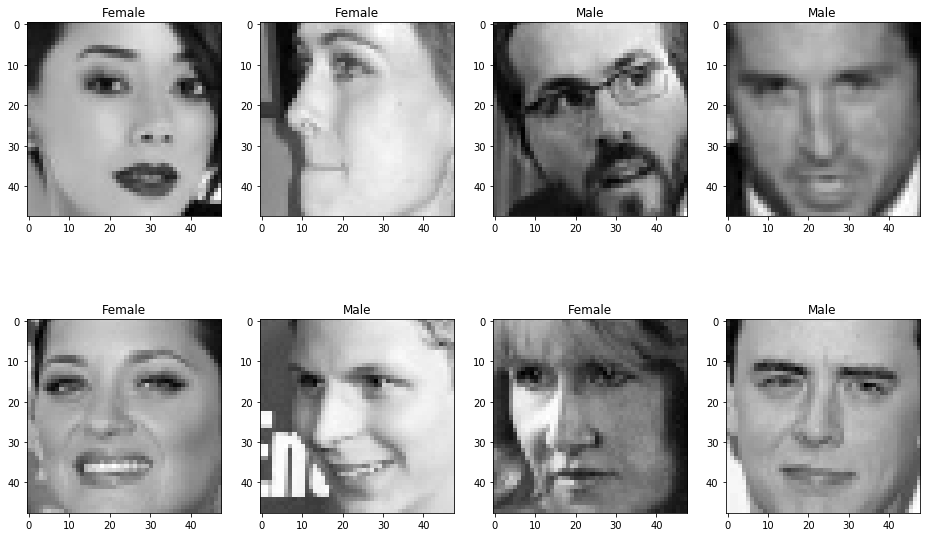

In [0]:
plotFaces(2, 4, train)

## Model

In [0]:
model1 = models.Sequential([
    layers.Conv2D(filters=4, kernel_size=(3, 3), padding='same',
                  activation=activations.relu, 
                  input_shape=(train.width, train.height, train.channels), name='conv_1'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same',
                  activation=activations.relu, name='conv_2'),
    layers.MaxPooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                      activation=activations.relu, name='conv_3'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(2, activation=activations.sigmoid)
])

model1.compile(optimizer=optimizers.Adam(),
                   loss=losses.binary_crossentropy,
                   metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 48, 48, 4)         40        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 4)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 24, 8)         296       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

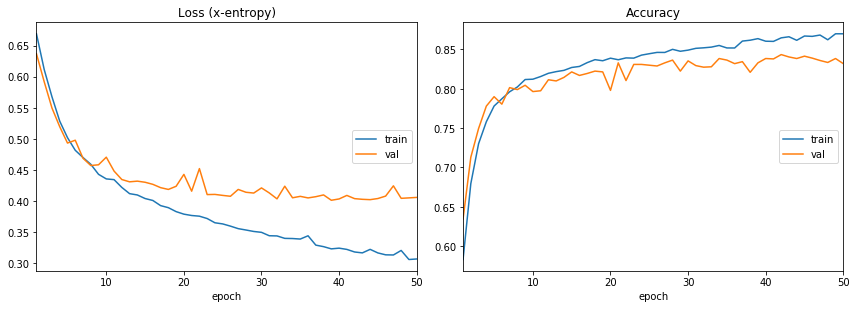

In [0]:
n_epochs = 50
metric_names = ['Loss (x-entropy)', 'Accuracy']
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metric_names,
                cell_size=(6,4), columns=2, iter_num=n_epochs, wait_num=1)
history1 = model1.fit(train.data, train.label,
                epochs=n_epochs, batch_size=train.batch_size, 
                validation_split=0.1, 
                verbose=0,
                callbacks=[tv_plot]);

Overfitting is observed : The validation loss and accuracy are plateauing while training is improving, and they are irregular (bumpy) compared to the training

In [0]:
#plotHistory(history1, True, False)

### 1.1 Test

In [0]:
y_est1 = model1.predict(test.data)

In [0]:
score = np.mean(np.argmax(test.label, axis=1) == np.argmax(y_est1, axis=1))
print("Accuracy : %.1f %%" % (score*100))

Accuracy : 80.3 %


Overfitting is confirmed, test accuracy is lower than the final validation accuracy.

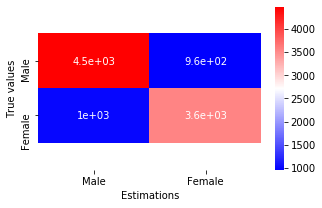

In [0]:
fig, ax = plt.subplots(figsize=(5, 3))
plotConfusionMatrix(np.argmax(test.label, axis=1), np.argmax(y_est1, axis=1), genders)

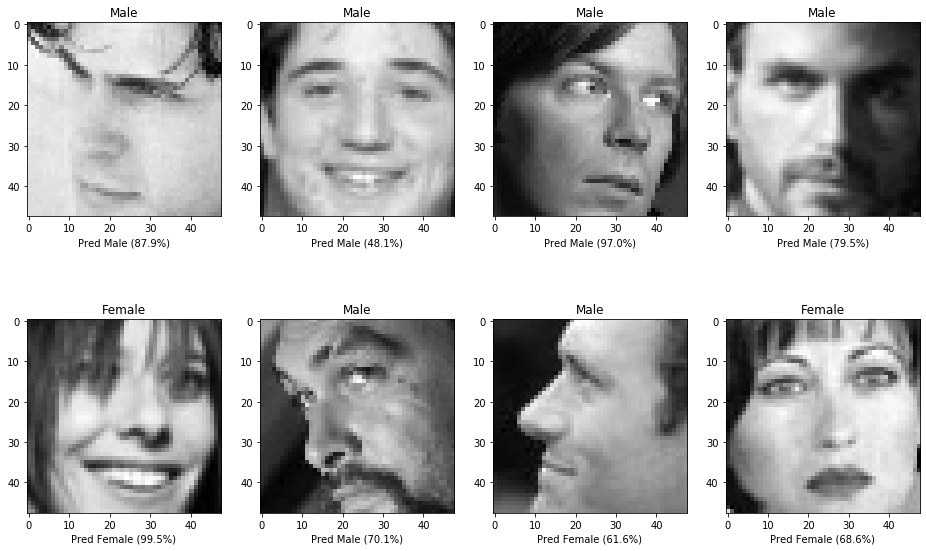

In [0]:
plotFaces(2, 4, test, y_est1)

### 1.2 Save model

In [0]:
model1.save('model1.h5')

## 2. More complexe architecture

In [0]:
n, h, w, c = train.data.shape

In [0]:
input_img = Input(shape=(h, w, 1))
layer_1 = Conv2D(4, (1,1), padding='same', activation='relu')(input_img)
layer_1 = Conv2D(6, (3,3), padding='same', activation='relu')(layer_1)
layer_1 = Conv2D(12, (1,1), padding='same', activation='relu')(layer_1)
layer_1 = AveragePooling2D((3, 3), strides=(1,1), padding='same')(layer_1)

layer_2 = Conv2D(4, (6, 6), padding='same', activation='relu')(input_img)
layer_2 = Conv2D(6, (2, 2), padding='same', activation='relu')(input_img)
layer_2 = Conv2D(12, (1, 1), padding='same', activation='relu')(input_img)
layer_2 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_2)

inception_1 = tf.keras.layers.concatenate([layer_1, layer_2], axis = 3)
x = Dense(5, activation='relu')(inception_1)

x = Conv2D(6, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
inception_2 = tf.keras.layers.concatenate([x, input_img], axis=3)

x = Conv2D(12, (2,2), padding='same', activation='relu')(inception_2)
x = Conv2D(16, (4,4), padding='same', activation='relu')(x)
x = Conv2D(18, (1,1), padding='same', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='relu')(x)
x = Flatten()(x)
output = Dense(2, activation='sigmoid')(x)

model = Model([input_img], output)

model.compile(optimizer=optimizers.Adam(),
                   loss=losses.binary_crossentropy,
                   metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 48, 48, 4)    8           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 48, 48, 6)    222         conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 48, 48, 12)   84          conv2d_29[0][0]                  
____________________________________________________________________________________________

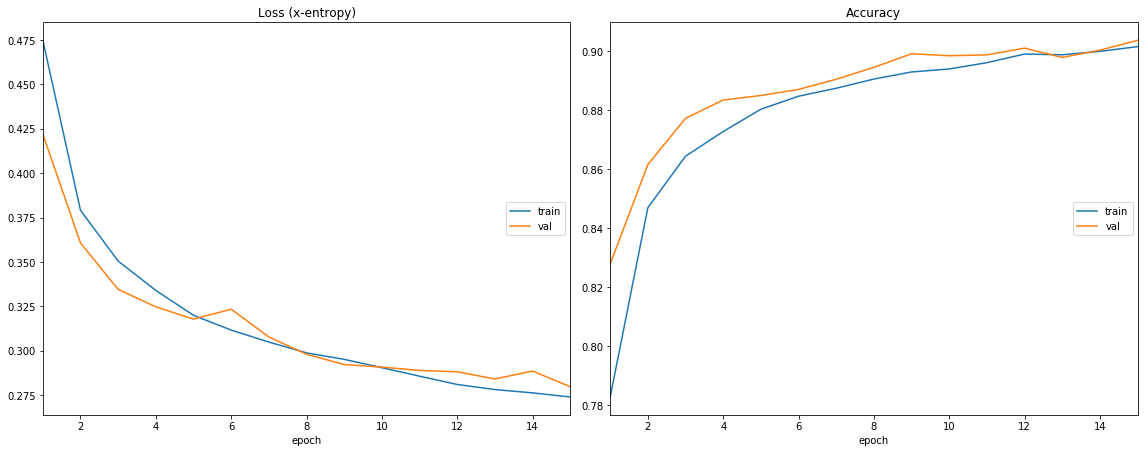

In [0]:
n_epochs = 15
metric_names = ['Loss (x-entropy)', 'Accuracy']
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metric_names,
                cell_size=(8,6), columns=2, iter_num=n_epochs, wait_num=1)
history1 = model.fit(train.data, train.label,
                epochs=n_epochs, batch_size=train.batch_size, 
                validation_split=0.20, 
                verbose=0,
                callbacks=[tv_plot])

In [0]:
y_est1 = model.predict(test.data)

In [0]:
score = np.mean(np.argmax(test.label, axis=1) == np.argmax(y_est1, axis=1))
print("Accuracy : %.1f %%" % (score*100))

Accuracy : 89.3 %


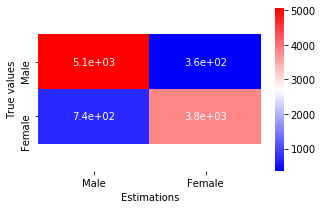

In [0]:
fig, ax = plt.subplots(figsize=(5, 3))
plotConfusionMatrix(np.argmax(test.label, axis=1), np.argmax(y_est1, axis=1), genders)

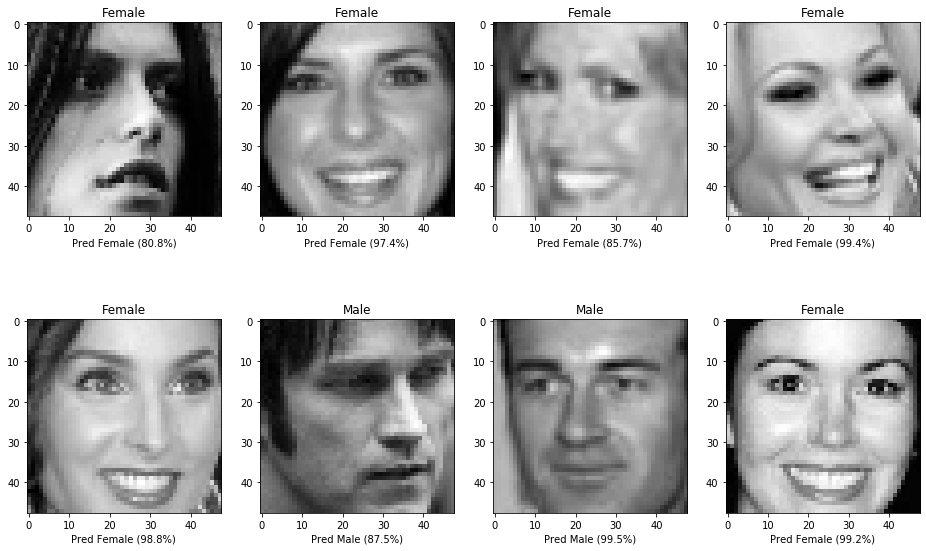

In [0]:
plotFaces(2, 4, test, y_est1)

### 1.2 Save model

In [0]:
output_path = f'/mnt/drive/My Drive/Colab Notebooks/mdi341-deeplearning/DeepLearning_Source_TF2/model-{score}.h5'
model.save(output_path)

## 2. Test on image from Internet

### 2.1 Quick resize

Resize without taking into account for aspect ratio, without focusing on the face

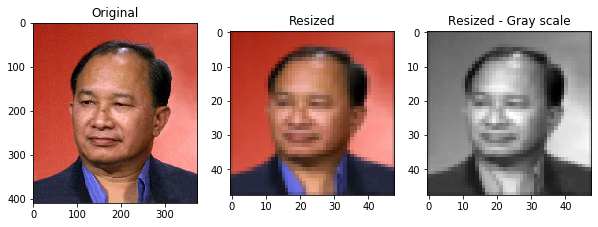

In [0]:
jw = io.imread('https://upload.wikimedia.org/wikipedia/commons/0/02/John_Woo_Cannes_2005.jpg')
jw1 = transform.resize(jw, (48, 48, 3), mode='constant').astype(np.float32)
jw1g = np.mean(jw1, axis=2)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(jw);
axes[0].set_title('Original')
axes[1].imshow(jw1);
axes[1].set_title('Resized')
axes[2].imshow(jw1g, cmap='gray');
axes[2].set_title('Resized - Gray scale');

Prediction without focusing on the head

In [0]:
predJw1Soft = model1.predict(jw1g.reshape(1, test.width, test.height, 1))
predJw1 = np.argmax(predJw1Soft[0])
print("Prediction for John Woo (unfocused) : %s (%.1f%%)" % (genders[predJw1], predJw1Soft[0,predJw1]*100))

Prediction for John Woo (unfocused) : Female (72.5%)


### 2.2 Manual crop to focus on face

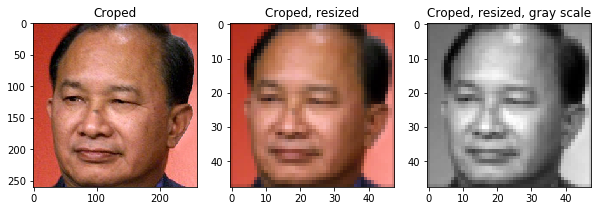

In [0]:
jw2   = jw[60:320, 60:320]
jw2r  = transform.resize(jw2, (48, 48, 3), mode='constant').astype(np.float32)
jw2g = np.mean(jw2r, axis=2)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(jw2);
axes[0].set_title('Croped')
axes[1].imshow(jw2r);
axes[1].set_title('Croped, resized')
axes[2].imshow(jw2g, cmap='gray');
axes[2].set_title('Croped, resized, gray scale');

In [0]:
predJw2Soft = model1.predict(jw2g.reshape(1, test.width, test.height, 1))
predJw2 = np.argmax(predJw2Soft[0])
print("Prediction for John Woo (focused) : %s (%.1f%%)" % (genders[predJw2], predJw2Soft[0, predJw2]*100))

Prediction for John Woo (focused) : Male (99.3%)


## 3. Script to load and apply

## 4. Adversarial example

In [0]:
# Load the model
model_path = Path('/mnt/drive/My Drive/Colab Notebooks/mdi341-deeplearning/DeepLearning_Source_TF2/model-0.8929.h5')
model = tf.keras.models.load_model(model_path)

In [0]:
def adversarial_pattern(image, true_label):
  image = tf.cast(image, tf.float32)
  with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.binary_crossentropy(true_label, prediction)
  
  gradient = tape.gradient(loss, image)  
  signed_grad = tf.sign(gradient)
  
  return signed_grad

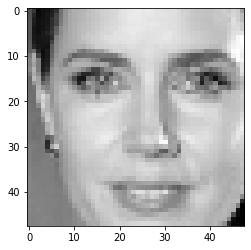

In [92]:
n = train.data.shape[0]
index = np.random.randint(0, n)
image = train.data[index, :,:,:]

# We compute a wrong label
label = train.label[index, :]
plt.imshow(image.reshape(48, 48), cmap='gray')
print(f'True label: {np.argmax(label)}')

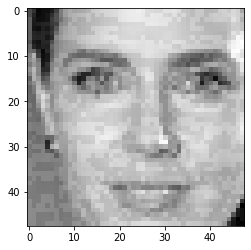

In [98]:
eps = 0.03

perturbations = adversarial_pattern(image.reshape((1, 48, 48, 1)), label).numpy()
adversarial = image + perturbations * eps

plt.imshow(adversarial.reshape(48, 48), cmap='gray')

In [107]:
pred = model.predict(adversarial.reshape((1, 48, 48, 1)))
false_label = np.argmax(pred)
print(f'False label: {false_label}\n'
      f'Confidence: {pred[0][0]}')

False label: 0
Confidence: 0.9996925592422485


## 5. Regularization

In [0]:
model2 = models.Sequential([
    layers.Conv2D(filters=4, kernel_size=(3, 3), padding='same',
                  input_shape=(train.width, train.height, train.channels),
                  activation=activations.relu, name='conv_1'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same',
                  activation=activations.relu, name='conv_2'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                      activation=activations.relu, name='conv_3'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(2, activation=activations.sigmoid)
])

model2.compile(optimizer=optimizers.Adam(),
                   loss=losses.binary_crossentropy,
                   metrics=['accuracy'])

#model2.summary()

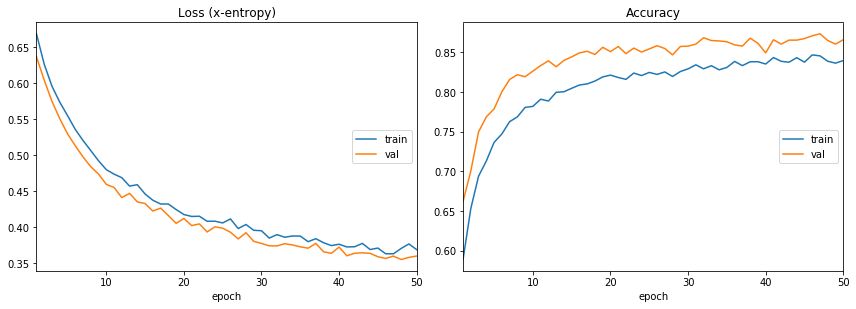

In [0]:
n_epochs = 50
metric_names = ['Loss (x-entropy)', 'Accuracy']
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metric_names,
                cell_size=(6,4), columns=2, iter_num=n_epochs, wait_num=1)
history2 = model2.fit(train.data, train.label,
                epochs=n_epochs, batch_size=train.batch_size, 
                validation_split=0.1, 
                verbose=0,
                callbacks=[tv_plot]);

With regularization (dropout) :
- The plateau of the validation loss @ 0.43 is gone, but there seems to be a plateau  @ 0.40
- Convergence is faster, the validation is well over 80% accuracy at epoch #10, was barely 80% previously
- The training performance is lower due to the dropout (not applied during validation)

### 2.1 Test

In [0]:
y_est2 = model2.predict(test.data)

In [0]:
score = np.mean(np.argmax(test.label, axis=1) == np.argmax(y_est2, axis=1))
print("Score : %.1f %%" % (score*100))

Score : 82.6 %


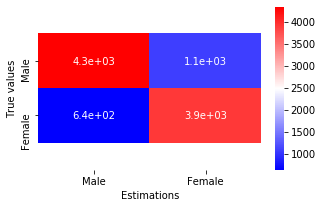

In [0]:
fig, ax = plt.subplots(figsize=(5, 3))
plotConfusionMatrix(np.argmax(test.label, axis=1), np.argmax(y_est2, axis=1), genders)

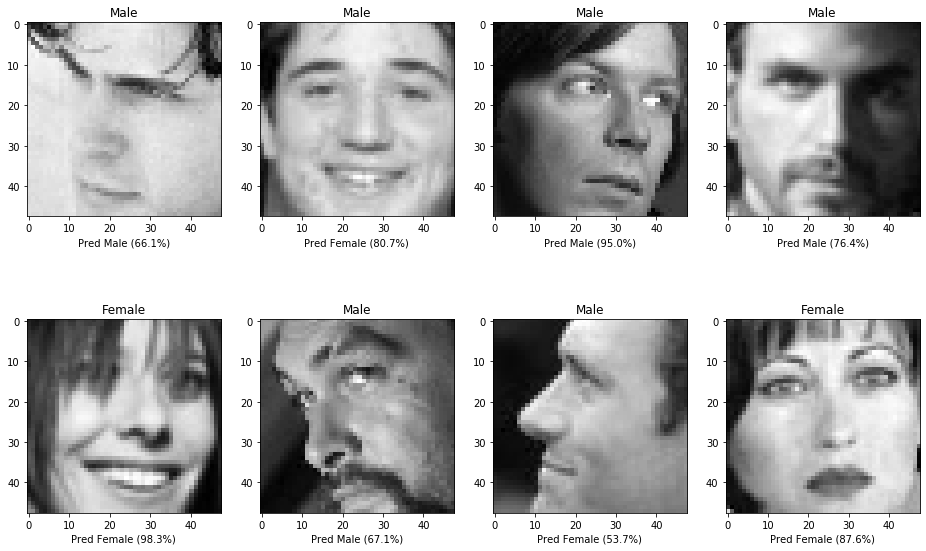

In [0]:
plotFaces(2, 4, test, y_est2)

In [0]:
predJw1Soft2 = model2.predict(jw1g.reshape(1, test.width, test.height, 1))
predJw12 = np.argmax(predJw1Soft2[0])
print("Prediction for John Woo (unfocused) : %s (%.1f%%)" % (genders[predJw12], predJw1Soft2[0,predJw12]*100))

Prediction for John Woo (unfocused) : Female (87.9%)


In [0]:
predJw2Soft2 = model2.predict(jw2g.reshape(1, test.width, test.height, 1))
predJw22 = np.argmax(predJw2Soft2[0])
print("Prediction for John Woo (focused) : %s (%.1f%%)" % (genders[predJw22], predJw2Soft2[0, predJw22]*100))

Prediction for John Woo (focused) : Female (58.3%)


### 2.2 Save model

In [0]:
model2.save('model2.h5')